### Import libraries

In [2]:
import pandas as pd
import numpy as np
from bs4 import BeautifulSoup
import requests
import pgeocode

import json 
from geopy.geocoders import Nominatim 
from opencage.geocoder import OpenCageGeocode


from pandas.io.json import json_normalize 

import matplotlib.cm as cm
import matplotlib.colors as colors

import matplotlib.pyplot as plt

from sklearn.cluster import KMeans

import folium
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)


# To get the towns in Warwickshire

### Datascraping with BeautifulSoup

In [3]:
source1=requests.get('https://worldpostalcode.com/united-kingdom/england/warwickshire').text
soup1=BeautifulSoup(source1,'lxml')

In [4]:
towns=[]
codes=[]
for j in range(283):
    t=soup1.find_all('div',class_='place')[j].text
    towns.append(t)
for i in range(283):
    c=soup1.find_all('div',class_='code')[i].text
    codes.append(c)



#### Converting lists from scraped data to a dataframe

In [5]:
df1=pd.DataFrame(codes)
df1['Towns']=towns
df1.columns=['Postal_Codes','Towns']
df1.head()

,Postal_Codes,Towns
0,CV36,Admington
1,B49,Alcester
2,CV37,Alderminster
3,CV37,Alveston
4,CV10,Ansley


There are 283 towns in warwickshire,but out of these towns Woodend,Southam and Exhall have two postcodes as there are two towns in the same name.So let us split the postcodes to get the appropriate venues.

In [6]:
df1.loc[df1.Towns.isin(['Southam','Exhall','Wood End'])]

df1.drop([89,223,278],inplace=True)

In [7]:
dictionary=[{'Postal_Codes':'B49','Towns':'Exhall,Stratford-upon-Avon'},
           {'Postal_Codes':'CV7','Towns':'Exhall,Nuneaton & Bedworth'},
           {'Postal_Codes':'CV47','Towns':'Southam'},
           {'Postal_Codes':'B94','Towns':'Wood End,Stratford-upon-Avon'},
           {'Postal_Codes':'CV9','Towns':'Wood_End,North Warwickshire'}]

In [8]:
df1=df1.append(dictionary,ignore_index=True,sort=True)

In [9]:
df1.shape

(285, 2)

There were not much information about the Southam town with the postcode CV33 so we ignore that town and hence in total we have a dataset of 285 towns in Warwickshire

# To find the latitude and longitude of the towns using OpenCage API

In [17]:
key='56dff2bb74094ccf83c8d040cafa4629'

In [11]:
geocoder=OpenCageGeocode(key)

In [12]:
df1['County']='Warwickshire,England'
df1.head()

,Postal_Codes,Towns,County
0,CV36,Admington,"Warwickshire,England"
1,B49,Alcester,"Warwickshire,England"
2,CV37,Alderminster,"Warwickshire,England"
3,CV37,Alveston,"Warwickshire,England"
4,CV10,Ansley,"Warwickshire,England"


In [13]:
list_lat = []  

list_long = []



for index, row in df1.iterrows(): # iterate over rows in dataframe



    Town = row['Towns']
    County = row['County']       
    query = str(Town)+','+str(County)

    results = geocoder.geocode(query)   
    lat = results[0]['geometry']['lat']
    long = results[0]['geometry']['lng']

    list_lat.append(lat)
    list_long.append(long)

# create new columns from lists    

df1['lat'] = list_lat   

df1['lng'] = list_long


In [18]:
df1_ed=df1.drop(['Postal_Codes','County'],axis=1)
df1_ed.head()

,Towns,lat,lng
0,Admington,52.113355,-1.707347
1,Alcester,52.217618,-1.868442
2,Alderminster,52.135912,-1.666328
3,Alveston,52.206518,-1.660409
4,Ansley,52.521885,-1.563154


# To get the bookstores in Warwickshire 

In [15]:
CLIENT_ID = 'G4JZLP1DYRETG2ND1IMPN1YHLZCERPZR5Y14HH03KDFENEQZ' 
CLIENT_SECRET = 'L5XMRZH0YJ0AH4WYRHTWIQUG0IKQGTBN3OR4F5SGMSQKEHBV' 
VERSION = '20180605' 


In [16]:
address='Warwickshire,England,UK'
geolocator=Nominatim(user_agent='uk_explorer',timeout=100000)
location=geolocator.geocode(address)
latitude=location.latitude
longitude=location.longitude
Warwickshire_location=[latitude,longitude]

print('Warwickshire_location: {}'.format(Warwickshire_location))


Warwickshire_location: [52.32130635, -1.5536905536661392]


## To get bookstores within 5km radius

In [19]:
def getNearbyVenues(names, latitudes, longitudes,search_query, radius=5000,limit=100):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
       
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&query={}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng,
            search_query,
            radius, 
            limit)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Town', 
                  'Town Latitude', 
                  'Town Longitude', 
                  'Store/library name', 
                  'Store/library Latitude', 
                  'Store/library Longitude', 
                  'Store/library Category']
    return(nearby_venues)

In [20]:
bookstores_df=getNearbyVenues(names=df1['Towns'],
                               latitudes=df1['lat'],
                               longitudes=df1['lng'],
                             search_query='Book Stores')

In [21]:
print(bookstores_df.shape)
bookstores_df.head()

(432, 7)


,Town,Town Latitude,Town Longitude,Store/library name,Store/library Latitude,Store/library Longitude,Store/library Category
0,Alveston,52.206518,-1.660409,Waterstones,52.192307,-1.706515,Bookstore
1,Alveston,52.206518,-1.660409,WHSmith,52.200316,-1.711133,Bookstore
2,Alveston,52.206518,-1.660409,WHSmith,52.192468,-1.706244,Bookstore
3,Alveston,52.206518,-1.660409,The Works,52.192287,-1.704192,Bookstore
4,Alveston,52.206518,-1.660409,The Shakespeare Bookshop,52.193354,-1.708443,Bookstore


##### Group the bookstores to get no:of bookstores in each town

In [22]:
BS=bookstores_df.groupby('Town').count()

In [23]:
print('No:of towns:{}'.format(BS.shape[0]))
BS.head()

No:of towns:120


,Town Latitude,Town Longitude,Store/library name,Store/library Latitude,Store/library Longitude,Store/library Category
Town,,,,,,
Alveston,6,6,6,6,6,6
Ansley,1,1,1,1,1,1
Ansty,2,2,2,2,2,2
Ashorne,3,3,3,3,3,3
Ashow,6,6,6,6,6,6


#### Out 285 towns only 120 towns have bookstores within 5km radius

## Look for libraries in these 285 towns

In [25]:
libraries_df=getNearbyVenues(names=df1['Towns'],latitudes=df1['lat'],longitudes=df1['lng'],search_query='Libraries')


In [26]:
print(libraries_df.shape)
libraries_df.head()

(233, 7)


,Town,Town Latitude,Town Longitude,Store/library name,Store/library Latitude,Store/library Longitude,Store/library Category
0,Alcester,52.217618,-1.868442,Alcester library and info centre,52.214742,-1.869571,Library
1,Alveston,52.206518,-1.660409,Stratford upon Avon Library,52.193697,-1.707779,Library
2,Alveston,52.206518,-1.660409,Wellesbourne Library & Wellies Children Centre,52.190330,-1.599002,Library
3,Ansley,52.521885,-1.563154,Camp Hill Library,52.530984,-1.506678,Library
4,Ansty,52.445493,-1.419254,Caludon Library,52.413467,-1.451461,Library


In [27]:
LB=libraries_df.groupby('Town').count()
print('No:of towns with libraries: {}'.format(LB.shape[0]))
LB.head()

No:of towns with libraries: 140


,Town Latitude,Town Longitude,Store/library name,Store/library Latitude,Store/library Longitude,Store/library Category
Town,,,,,,
Alcester,1,1,1,1,1,1
Alveston,2,2,2,2,2,2
Ansley,1,1,1,1,1,1
Ansty,2,2,2,2,2,2
Ardens Grafton,1,1,1,1,1,1


## Join the libraries and bookstores dataframe

In [28]:
dataframe=pd.concat([bookstores_df,libraries_df])
dataframe.shape

(665, 7)

In [29]:
dataframe1=dataframe.groupby('Town').count()
dataframe1.shape

(169, 6)

Therefore out of 285 towns 169 of them have libraries,bookstores or discount stores,while the remainig 116 towns donot have a bookstore or library within 5 km radius.Hence we may check out to get a best location to start a bookstore or a library in any of these towns by studying their population and other factors like vicinity to schools and colleges.

## Towns that donot have libraries or bookstores within 5km radius

In [30]:
NBL_df=df1.loc[~df1['Towns'].isin(dataframe['Town'])]
print('No:of towns with no libraries or bookstores within 5km : {}'.format(NBL_df.shape[0]))
NBL_df.head()

No:of towns with no libraries or bookstores within 5km : 116


,Postal_Codes,Towns,County,lat,lng
0,CV36,Admington,"Warwickshire,England",52.113355,-1.707347
2,CV37,Alderminster,"Warwickshire,England",52.135912,-1.666328
7,CV37,Armscote,"Warwickshire,England",52.100021,-1.646243
13,B95,Aston Cantlow,"Warwickshire,England",52.237753,-1.799086
14,CV9,Atherstone,"Warwickshire,England",52.577244,-1.543395


## To get population of these towns

In [31]:
source2=requests.get('https://www.ebayinuk.co.uk/warwickshire-towns-villages-population/').text
soup2=BeautifulSoup(source2,'lxml')

In [32]:
towns2=[]

for i in range (564):
    t2=soup2.find_all('tbody')[1]
    t=t2.find_all('td')[i].text
    towns2.append(t)

In [33]:
towns2[0:10]

['',
 'TOWN/VILLAGE',
 'POPULATION',
 'STATUS',
 '1',
 'Nuneaton',
 '81,548',
 'Town',
 '2',
 'Rugby']

In [34]:
unwanted_num = {"","TOWN/VILLAGE",'POPULATION','STATUS','Town','Village','1'} 
  
list1 = [ele for ele in towns2 if ele not in unwanted_num] 
list1[0:10]  

['Nuneaton',
 '81,548',
 '2',
 'Rugby',
 '70,654',
 '3',
 'Leamington Spa',
 '49,548',
 '4',
 'Bedworth']

In [35]:
new_list=[v for i, v in enumerate(list1) if (i + 1) % 3 != 0]
new_list[0:10]

['Nuneaton',
 '81,548',
 'Rugby',
 '70,654',
 'Leamington Spa',
 '49,548',
 'Bedworth',
 '32,326',
 'Warwick',
 '31,325']

In [36]:
array_town = new_list[::2]
array_pop = new_list[1:][::2]


In [37]:
print('Towns: {}'.format(array_town[0:9]))

print('Population: {}'.format(array_pop[0:10]))

Towns: ['Nuneaton', 'Rugby', 'Leamington Spa', 'Bedworth', 'Warwick', 'Kenilworth', 'Whitnash', 'Atherstone', 'Polesworth']
Population: ['81,548', '70,654', '49,548', '32,326', '31,325', '22,487', '8,874', '8,798', '8,427', '8,239']


In [38]:
print('length of array_pop: {}\n length of array_town: {}'.format(len(array_pop),len(array_town)))

length of array_pop: 140
 length of array_town: 140


### Convert the list of towns and its popultion to a dataframe

In [39]:
df2=pd.DataFrame(array_town)
df2['Population']=array_pop
df2.columns=['Towns','Population']
df2.head()

,Towns,Population
0,Nuneaton,"81,548"
1,Rugby,"70,654"
2,Leamington Spa,"49,548"
3,Bedworth,"32,326"
4,Warwick,"31,325"


In [40]:
df3=NBL_df.loc[NBL_df['Towns'].isin(df2['Towns'])]

df3=df3.drop(['Postal_Codes','County'],axis=1)

print('No:of towns without bookstores/libraries and their population known: {}'.format(df3.shape[0]))

df3.head()

No:of towns without bookstores/libraries and their population known: 49


,Towns,lat,lng
0,Admington,52.113355,-1.707347
2,Alderminster,52.135912,-1.666328
13,Aston Cantlow,52.237753,-1.799086
14,Atherstone,52.577244,-1.543395
17,Austrey,52.656038,-1.567487


In [41]:
df3=df2.merge(df3,how='inner')
df3.head()

,Towns,Population,lat,lng
0,Atherstone,"8,798",52.577244,-1.543395
1,Kineton,"2,338",52.157470,-1.508069
2,Hatton,"2,317",52.295213,-1.672907
3,Salford Priors,"1,549",52.158453,-1.891547
4,Austrey,"1,522",52.656038,-1.567487


### To check for schools in these towns

In [42]:
schools_df=getNearbyVenues(names=df3['Towns'],latitudes=df3['lat'],longitudes=df3['lng'],search_query=' Elementary schools')

schools_df.head()

,Town,Town Latitude,Town Longitude,Store/library name,Store/library Latitude,Store/library Longitude,Store/library Category
0,Atherstone,52.577244,-1.543395,Ashleigh Nursery,52.580201,-1.555978,Elementary School
1,Kineton,52.157470,-1.508069,Kineton Primary School,52.156119,-1.503078,Elementary School
2,Kineton,52.157470,-1.508069,Temple Herdewyke Primary School,52.166369,-1.445505,Elementary School
3,Hatton,52.295213,-1.672907,Hopes And Dreams,52.304413,-1.646428,Elementary School
4,Hatton,52.295213,-1.672907,Claverdon Primary School,52.300687,-1.625418,Elementary School


In [43]:
schools_df1=getNearbyVenues(names=df3['Towns'],latitudes=df3['lat'],longitudes=df3['lng'],search_query='High Schools')

schools_df1.head()

,Town,Town Latitude,Town Longitude,Store/library name,Store/library Latitude,Store/library Longitude,Store/library Category
0,Kineton,52.157470,-1.508069,Kineton High School,52.156439,-1.502436,High School
1,Hatton,52.295213,-1.672907,Henley-in-Arden High School,52.300484,-1.625241,High School
2,Tredington,52.090291,-1.625408,Shipston High School,52.065269,-1.632924,High School
3,Tredington,52.090291,-1.625408,Shipston High School,52.050171,-1.615436,High School
4,Ilmington,52.089038,-1.693439,Shipston High School,52.065269,-1.632924,High School


In [44]:
Schools_dataframe=pd.concat([schools_df,schools_df1])
print(Schools_dataframe.shape)
Schools_dataframe.head()

(79, 7)


,Town,Town Latitude,Town Longitude,Store/library name,Store/library Latitude,Store/library Longitude,Store/library Category
0,Atherstone,52.577244,-1.543395,Ashleigh Nursery,52.580201,-1.555978,Elementary School
1,Kineton,52.157470,-1.508069,Kineton Primary School,52.156119,-1.503078,Elementary School
2,Kineton,52.157470,-1.508069,Temple Herdewyke Primary School,52.166369,-1.445505,Elementary School
3,Hatton,52.295213,-1.672907,Hopes And Dreams,52.304413,-1.646428,Elementary School
4,Hatton,52.295213,-1.672907,Claverdon Primary School,52.300687,-1.625418,Elementary School


In [45]:
S_df=Schools_dataframe.groupby('Town').count()

S_df=S_df.reset_index(drop=False)

print(S_df.shape)

S_df.head()

(36, 7)


,Town,Town Latitude,Town Longitude,Store/library name,Store/library Latitude,Store/library Longitude,Store/library Category
0,Admington,1,1,1,1,1,1
1,Alderminster,1,1,1,1,1,1
2,Aston Cantlow,2,2,2,2,2,2
3,Atherstone,1,1,1,1,1,1
4,Austrey,1,1,1,1,1,1


There are 49 towns which donot have libraries or bookstores and whose population is known.Out of these towns 36 of them have elementary schools or high school in 5km radius.

In [46]:
df4=df3.loc[df3['Towns'].isin(Schools_dataframe['Town'])]
print(df4.shape)
df4.head()

(36, 4)


,Towns,Population,lat,lng
0,Atherstone,"8,798",52.577244,-1.543395
1,Kineton,"2,338",52.157470,-1.508069
2,Hatton,"2,317",52.295213,-1.672907
3,Salford Priors,"1,549",52.158453,-1.891547
4,Austrey,"1,522",52.656038,-1.567487


In [47]:
df5=Schools_dataframe['Town'].value_counts()

df5=pd.DataFrame(df5).reset_index()

print(df5.shape)

df5.columns=['Towns','No: of schools']

df5.head()

(36, 2)


,Towns,No: of schools
0,Norton Lindsey,9
1,Binton,5
2,Hatton,5
3,Thurlaston,5
4,Morton Bagot,5


In [50]:
df6=df4.merge(df5,left_on='Towns',right_on='Towns',how='inner')
df6.head()

,Towns,Population,lat,lng,No: of schools
0,Atherstone,"8,798",52.577244,-1.543395,1
1,Kineton,"2,338",52.157470,-1.508069,3
2,Hatton,"2,317",52.295213,-1.672907,5
3,Salford Priors,"1,549",52.158453,-1.891547,1
4,Austrey,"1,522",52.656038,-1.567487,1


In [54]:
df6['Population']=df6['Population'].str.replace(',','')

df6['Population'] = df6['Population'].astype(float)

### Population and No: of schools graph of towns without bookstores/ libraries

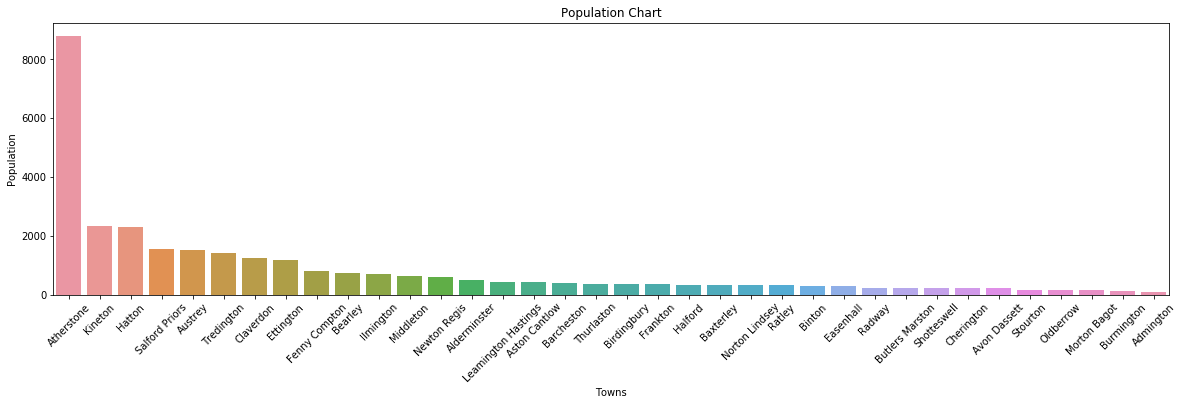

In [77]:
import seaborn as sns
plt.figure(figsize=(20,5))
plot1=sns.barplot(x=df6['Towns'],y=df6['Population'])
plot1.set_xticklabels(labels=df6['Towns'], rotation=45)
plt.title('Population Chart')
plt.show()

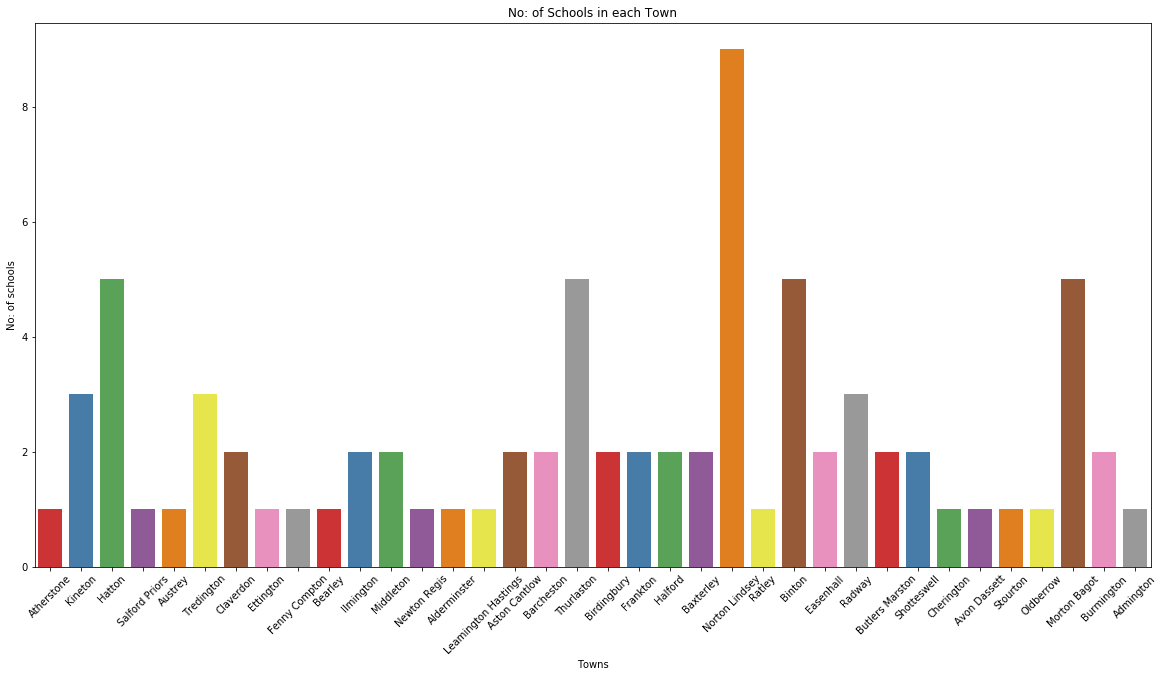

In [75]:
plt.figure(figsize=(20,10))
plot1=sns.barplot(x=df6['Towns'],y=df6['No: of schools'],palette='Set1')
plot1.set_xticklabels(labels=df6['Towns'], rotation=45)
plt.title('No: of Schools in each Town')
plt.show()

In [49]:
map3=folium.Map(location=Warwickshire_location,zoom_start=9)


for lat,lng,nei in zip(df6['lat'],df6['lng'],df6['Towns']):
    
    label=folium.Popup(str(nei), parse_html=True)
    
    folium.CircleMarker([lat,lng],radius=5,popup=label,color='blue',fill_opacity=0.7).add_to(map3)
    
map3

#### Data check

In [104]:
list1=['Atherstone','Kineton','Hatton']

In [106]:
one=Schools_dataframe.loc[Schools_dataframe['Town'].isin(list1)]
one.columns=['Town','Town latitude','Town longitude','School','School latitude','School longitude','School Category']
one

,Town,Town latitude,Town longitude,School,School latitude,School longitude,School Category
0,Atherstone,52.577244,-1.543395,Ashleigh Nursery,52.580201,-1.555978,Elementary School
1,Kineton,52.157470,-1.508069,Kineton Primary School,52.156119,-1.503078,Elementary School
2,Kineton,52.157470,-1.508069,Temple Herdewyke Primary School,52.166369,-1.445505,Elementary School
3,Hatton,52.295213,-1.672907,Hopes And Dreams,52.304413,-1.646428,Elementary School
4,Hatton,52.295213,-1.672907,Claverdon Primary School,52.300687,-1.625418,Elementary School
5,Hatton,52.295213,-1.672907,Budbrooke Primary School,52.300545,-1.625288,Elementary School
6,Hatton,52.295213,-1.672907,Ferncumbe Primary School,52.300542,-1.625113,Elementary School
0,Kineton,52.157470,-1.508069,Kineton High School,52.156439,-1.502436,High School
1,Hatton,52.295213,-1.672907,Henley-in-Arden High School,52.300484,-1.625241,High School


Atherstone is a smart option to start a bookstore as the population here compared to other towns are really high.Hatton and Kineton also have appreciable population and proximity to more no: of schools hence those towns would also serve as a choice to start a library or a bookstore as no other such enterprices are reported here.

## Checking out other towns that already have libraries and bookstores

In [80]:
dataframe_onehot=pd.get_dummies(dataframe[['Store/library Category']],prefix="",prefix_sep="")

dataframe_onehot['Towns']=dataframe['Town']

fix_col=[dataframe_onehot.columns[-1]]+list(dataframe_onehot.columns[:-1])

dataframe_onehot=dataframe_onehot[fix_col]

dataframe_onehot.head()

,Towns,Bookstore,College Library,Comic Shop,Discount Store,Library
0,Alveston,1,0,0,0,0
1,Alveston,1,0,0,0,0
2,Alveston,1,0,0,0,0
3,Alveston,1,0,0,0,0
4,Alveston,1,0,0,0,0


In [82]:
dataframe_grouped = dataframe_onehot.groupby('Towns').mean().reset_index()

dataframe_grouped.head()

to_cluster=dataframe_grouped.drop(['Towns','College Library'],axis=1)

print(to_cluster.shape)

to_cluster.head()

(169, 4)


,Bookstore,Comic Shop,Discount Store,Library
0,0.000,0.0,0.000,1.00
1,0.625,0.0,0.125,0.25
2,0.500,0.0,0.000,0.50
3,0.500,0.0,0.000,0.50
4,0.000,0.0,0.000,1.00


In [83]:
to_cluster_ed=to_cluster.drop(['Comic Shop'],axis=1)
to_cluster_ed.head()

,Bookstore,Discount Store,Library
0,0.000,0.000,1.00
1,0.625,0.125,0.25
2,0.500,0.000,0.50
3,0.500,0.000,0.50
4,0.000,0.000,1.00


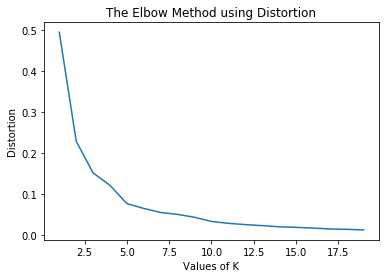

In [84]:
from scipy.spatial.distance import cdist 

distortions = [] 
inertias = [] 
mapping1 = {} 
mapping2 = {} 
K = range(1,20) 
  
for k in K: 
    #Building and fitting the model 
    kmeanModel = KMeans(n_clusters=k,random_state=0).fit(to_cluster) 
    kmeanModel.fit(to_cluster)     
      
    distortions.append(sum(np.min(cdist(to_cluster, kmeanModel.cluster_centers_, 
                      'euclidean'),axis=1)) / to_cluster.shape[0]) 
    inertias.append(kmeanModel.inertia_) 
  
    mapping1[k] = sum(np.min(cdist(to_cluster, kmeanModel.cluster_centers_, 
                 'euclidean'),axis=1)) / to_cluster.shape[0] 
    mapping2[k] = kmeanModel.inertia_ 

plt.plot(K, distortions) 
plt.xlabel('Values of K') 
plt.ylabel('Distortion') 
plt.title('The Elbow Method using Distortion') 
plt.show() 

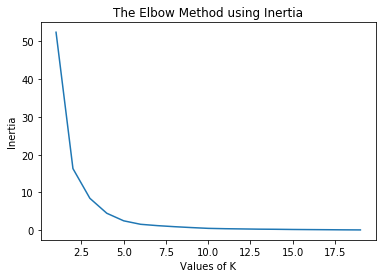

In [85]:
plt.plot(K, inertias) 
plt.xlabel('Values of K') 
plt.ylabel('Inertia') 
plt.title('The Elbow Method using Inertia') 
plt.show() 

In [86]:
num_k=5
kmeans=KMeans(n_clusters=num_k,random_state=0).fit(to_cluster)
labels=kmeans.labels_

In [87]:
dataframe_grouped['Cluster Labels']=labels

#### Dataframe check

In [1]:
dataframe_grouped.loc[dataframe_grouped['Cluster Labels']==4]

In [89]:
dataframe1=df1.loc[df1['Towns'].isin(dataframe_grouped['Towns'])]
print(dataframe1.shape)
dataframe1=dataframe1.drop(['Postal_Codes','County'],axis=1)
dataframe1.head()

(169, 5)


,Towns,lat,lng
1,Alcester,52.217618,-1.868442
3,Alveston,52.206518,-1.660409
4,Ansley,52.521885,-1.563154
5,Ansty,52.445493,-1.419254
6,Ardens Grafton,52.186740,-1.831906


In [90]:
dataframe1=pd.merge(left=dataframe1, right=dataframe_grouped[['Towns','Cluster Labels']], how='right', on='Towns')
dataframe1.head()

,Towns,lat,lng,Cluster Labels
0,Alcester,52.217618,-1.868442,1
1,Alveston,52.206518,-1.660409,4
2,Ansley,52.521885,-1.563154,3
3,Ansty,52.445493,-1.419254,3
4,Ardens Grafton,52.186740,-1.831906,1


In [91]:
Cluster0 = dataframe1.loc[dataframe1['Cluster Labels'] == 0]
print('Cluster of {} towns with discount stores alone'.format(Cluster0.shape[0]))
Cluster0.head()

Cluster of 4 towns with libraries alone


,Towns,lat,lng,Cluster Labels
80,Kingsbury,52.564476,-1.682967,0
101,Nether Whitacre,52.533660,-1.660379,0
111,Over Whitacre,52.516579,-1.627471,0
158,Willey,52.459013,-1.272541,0


In [93]:
Cluster1 = dataframe1.loc[dataframe1['Cluster Labels'] == 1]
print('Cluster of {} towns with libraries only'.format(Cluster1.shape[0]))
Cluster1.head()

Cluster of 49 towns with libraries only


,Towns,lat,lng,Cluster Labels
0,Alcester,52.217618,-1.868442,1
4,Ardens Grafton,52.186740,-1.831906,1
5,Arrow,52.207390,-1.884306,1
6,Ascott,52.009626,-1.531858,1
16,Bascote,52.270277,-1.408395,1


In [95]:
Cluster2 = dataframe1.loc[dataframe1['Cluster Labels'] == 2]
print('Cluster of {} towns with bookstores only'.format(Cluster2.shape[0]))
Cluster2.head()

Cluster of 25 towns with bookstores only


,Towns,lat,lng,Cluster Labels
12,Baddesley Ensor,52.580957,-1.603396,2
14,Barford,52.245425,-1.606049,2
28,Budbrooke,52.287539,-1.622811,2
34,Chadshunt,52.173529,-1.491873,2
37,Chesterton Green,52.224711,-1.491114,2


In [97]:
Cluster3 = dataframe1.loc[dataframe1['Cluster Labels'] == 3]
print('Cluster of {} towns with more discount stores and libraries than bookstores'.format(Cluster3.shape[0]))
Cluster3.head()

Cluster of 39 towns with more discount stores and libraries than bookstores


,Towns,lat,lng,Cluster Labels
2,Ansley,52.521885,-1.563154,3
3,Ansty,52.445493,-1.419254,3
11,Attleborough,52.515375,-1.452127,3
13,Baginton,52.371148,-1.494883,3
15,Barnacle,52.459158,-1.431444,3


In [99]:
Cluster4 = dataframe1.loc[dataframe1['Cluster Labels'] == 4]
print('Cluster of {} towns with more bookstores than discount stores and libraries'.format(Cluster4.shape[0]))
Cluster4.head()

Cluster of 52 towns with more bookstores than discount stores and libraries


,Towns,lat,lng,Cluster Labels
1,Alveston,52.206518,-1.660409,4
7,Ashorne,52.216586,-1.554447,4
8,Ashow,52.330552,-1.545596,4
9,Astley,52.501420,-1.542541,4
10,Atherstone On Stour,52.156980,-1.700660,4


## Map of all the clusters

In [107]:
map0=folium.Map(location=Warwickshire_location,zoom_start=11)

x = np.arange(num_k)

ys=[i+x+(i*x)**2 for i in range(num_k)]

colors_array=cm.rainbow(np.linspace(0,1,len(ys)))

rainbow=[colors.rgb2hex(i) for i in colors_array]

marker_colors=[]

for lat,lng,nei,clus in zip(dataframe1['lat'],dataframe1['lng'],dataframe1['Towns'],dataframe1['Cluster Labels']):
    
    label=folium.Popup(str(nei) + ' cluster ' + str(clus), parse_html=True)
    
    folium.CircleMarker([lat,lng],radius=5,popup=label,color=rainbow[clus-1],fill_opacity=0.7).add_to(map0)
    
map0

Out of 170 towns 49 of them have no bookstores or discount stores but libraries alone.Likewise 4 of them have discountstores alone and 25 of them have bookstores alone.52 towns have more bookstores than discount stores and 40 of them have discount stores more than bookstores.We can get the best location for bookstores,discount stores and libraries by careful examination of these cluster of towns. To get a best location for a bookstore/discount store we may look into cluster_0 which have only libraries near them.

# To find another location to start a bookstore or a discount store in a town where there are libraries

In [109]:
LB1=df2.loc[df2['Towns'].isin(Cluster1['Towns'])]
print(LB1.shape)
LB1.head()

(16, 2)


,Towns,Population
12,Alcester,"6,279"
13,Bulkington,"6,147"
28,Mancetter,"2,338"
51,Brinklow,"1,104"
65,Bubbenhall,652


In [112]:
LB2=df1.merge(LB1,left_on='Towns',right_on='Towns',how='inner')
print(LB2.shape)
LB2.head()

(16, 6)


,Postal_Codes,Towns,County,lat,lng,Population
0,B49,Alcester,"Warwickshire,England",52.217618,-1.868442,"6,279"
1,CV23,Brinklow,"Warwickshire,England",52.411811,-1.363277,"1,104"
2,B50,Broom,"Warwickshire,England",52.178504,-1.868562,557
3,CV8,Bubbenhall,"Warwickshire,England",52.350005,-1.468359,652
4,CV12,Bulkington,"Warwickshire,England",52.475791,-1.423134,"6,147"


In [114]:
LBschools_df1=getNearbyVenues(names=LB2['Towns'],latitudes=LB2['lat'],longitudes=LB2['lng'],search_query='Schools')
LBschools_df1.head()

,Town,Town Latitude,Town Longitude,Store/library name,Store/library Latitude,Store/library Longitude,Store/library Category
0,Alcester,52.217618,-1.868442,St. Benedict's RC High School,52.217824,-1.865981,High School
1,Alcester,52.217618,-1.868442,Alcester High School Technology College,52.220559,-1.857241,High School
2,Alcester,52.217618,-1.868442,Tiny Tribes,52.225628,-1.925902,Nursery School
3,Brinklow,52.411811,-1.363277,St. Margaret's C of E Primary School,52.375699,-1.396899,Elementary School
4,Broom,52.178504,-1.868562,Cleeve Prior First School,52.141080,-1.874304,School


In [115]:
LB2_df=LBschools_df1.drop(LBschools_df1.loc[LBschools_df1['Store/library Category']=='Nursery School'].index)
LB2_df.columns=['Town','Town Latitude','Town Longitude','School name','School latitude','School longitude','School category']
print(LB2_df.shape)
LB2_df.head()

(50, 7)


,Town,Town Latitude,Town Longitude,School name,School latitude,School longitude,School category
0,Alcester,52.217618,-1.868442,St. Benedict's RC High School,52.217824,-1.865981,High School
1,Alcester,52.217618,-1.868442,Alcester High School Technology College,52.220559,-1.857241,High School
3,Brinklow,52.411811,-1.363277,St. Margaret's C of E Primary School,52.375699,-1.396899,Elementary School
4,Broom,52.178504,-1.868562,Cleeve Prior First School,52.141080,-1.874304,School
5,Broom,52.178504,-1.868562,Bidford On Avon Primary School,52.167120,-1.859012,Elementary School


In [116]:
LB2_grouped=LB2_df.groupby('Town').count().reset_index(drop=False)
print(LB2_grouped.shape)
LB2_grouped.head()

(16, 7)


,Town,Town Latitude,Town Longitude,School name,School latitude,School longitude,School category
0,Alcester,2,2,2,2,2,2
1,Brinklow,1,1,1,1,1,1
2,Broom,5,5,5,5,5,5
3,Bubbenhall,6,6,6,6,6,6
4,Bulkington,3,3,3,3,3,3


In [117]:
LB2_df.loc[LB2_df['Town']=='Bubbenhall']

,Town,Town Latitude,Town Longitude,School name,School latitude,School longitude,School category
9,Bubbenhall,52.350005,-1.468359,Princethorpe College,52.336247,-1.421070,High School
10,Bubbenhall,52.350005,-1.468359,Jam Jam Boomerang,52.373178,-1.466941,Playground
11,Bubbenhall,52.350005,-1.468359,Adult Education Centre,52.388849,-1.468313,High School
12,Bubbenhall,52.350005,-1.468359,Arden University,52.369573,-1.467567,School
13,Bubbenhall,52.350005,-1.468359,L3 Airline Academy,52.370358,-1.486608,Flight School
14,Bubbenhall,52.350005,-1.468359,Atlantic Flight Training (AFT),52.370370,-1.486601,Flight School


In [118]:
LB2=LB2.drop(['Postal_Codes','County'],axis=1)

LB2['Population']=LB2['Population'].str.replace(',','')

LB2['Population'] = LB2['Population'].astype(float)

LB2= LB2.sort_values('Population',ascending=False)

LB2.head()

,Towns,lat,lng,Population
0,Alcester,52.217618,-1.868442,6279.0
4,Bulkington,52.475791,-1.423134,6147.0
12,Mancetter,52.569655,-1.530255,2338.0
1,Brinklow,52.411811,-1.363277,1104.0
3,Bubbenhall,52.350005,-1.468359,652.0


In [119]:
LB_df6=LB2_df['Town'].value_counts()

LB_df6=pd.DataFrame(LB_df6).reset_index()

print(LB_df6.shape)

LB_df6.columns=['Towns','No: of schools']

LB_df6.head()



(16, 2)


,Towns,No: of schools
0,Mancetter,7
1,Bubbenhall,6
2,Ufton,5
3,Broom,5
4,Church Lawford,4


In [120]:
LB_df7=LB2.merge(LB_df6,left_on='Towns',right_on='Towns',how='inner')
LB_df7

,Towns,lat,lng,Population,No: of schools
0,Alcester,52.217618,-1.868442,6279.0,2
1,Bulkington,52.475791,-1.423134,6147.0,3
2,Mancetter,52.569655,-1.530255,2338.0,7
3,Brinklow,52.411811,-1.363277,1104.0,1
4,Bubbenhall,52.350005,-1.468359,652.0,6
5,Great Alne,52.231303,-1.831837,571.0,2
6,Hampton Lucy,52.211642,-1.627343,564.0,2
7,Broom,52.178504,-1.868562,557.0,5
8,Church Lawford,52.384169,-1.341256,417.0,4
9,Loxley,52.173888,-1.626633,398.0,3


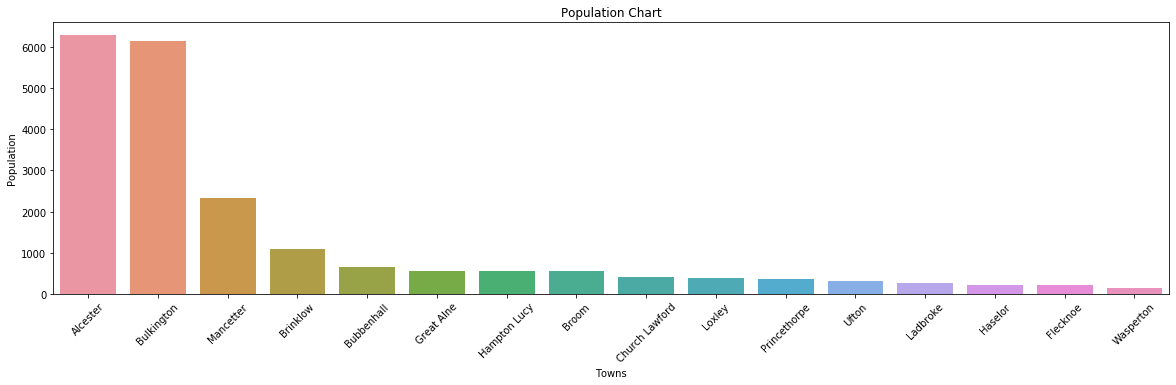

In [121]:
plt.figure(figsize=(20,5))
plot2=sns.barplot(x=LB_df7['Towns'],y=LB_df7['Population'])
plot2.set_xticklabels(labels=LB_df7['Towns'], rotation=45)
plt.title('Population Chart')
plt.show()

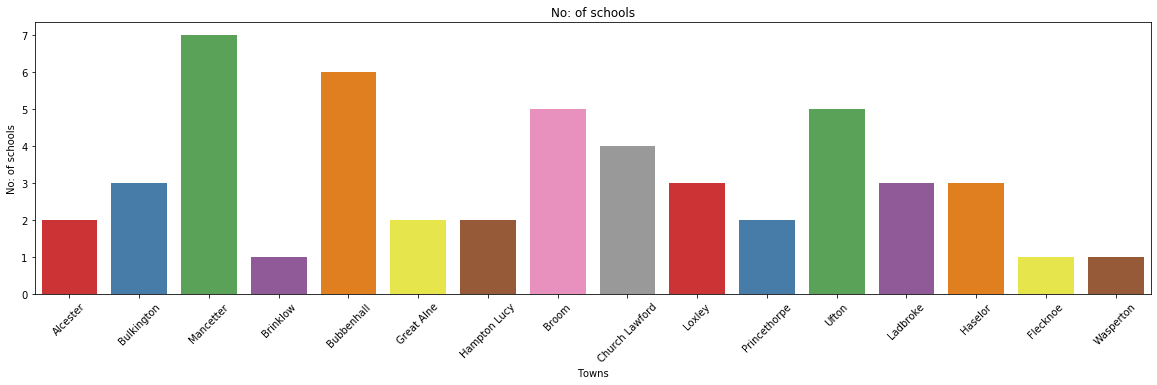

In [123]:
plt.figure(figsize=(20,5))
plot1=sns.barplot(x=LB_df7['Towns'],y=LB_df7['No: of schools'],palette='Set1')
plot1.set_xticklabels(labels=LB_df7['Towns'], rotation=45)
plt.title('No: of schools')
plt.show()

## Data check

In [126]:
list2=['Alcester','Bulkington','Mancetter']

In [127]:
LB2_df.loc[LB2_df['Town'].isin(list2)]

,Town,Town Latitude,Town Longitude,School name,School latitude,School longitude,School category
0,Alcester,52.217618,-1.868442,St. Benedict's RC High School,52.217824,-1.865981,High School
1,Alcester,52.217618,-1.868442,Alcester High School Technology College,52.220559,-1.857241,High School
15,Bulkington,52.475791,-1.423134,Grace Academy,52.438664,-1.445105,School
16,Bulkington,52.475791,-1.423134,Nicholas Chamberlaine Technology College,52.478781,-1.459379,High School
17,Bulkington,52.475791,-1.423134,Foxford school & community arts college,52.453694,-1.479097,High School
38,Mancetter,52.569655,-1.530255,Queen Elizabeth School,52.574515,-1.533522,School
39,Mancetter,52.569655,-1.530255,Racemeadow,52.580356,-1.538447,School
40,Mancetter,52.569655,-1.530255,Michael Drayton School,52.540921,-1.521498,School
41,Mancetter,52.569655,-1.530255,Nathaniel Infant School,52.538732,-1.520873,School
42,Mancetter,52.569655,-1.530255,Brooklyn Day Nursery,52.532475,-1.514399,School


In [128]:
dictionary=[{'Towns':'Atherstone','Population':8798,'No.of libraries':0,'No.of schools':1,'lat':52.577244,'lng':-1.54339552},
            {'Towns':'Alcester','Population':6279,'No.of libraries':1,'No.of schools':2,'lat':52.217618,'lng':-1.868442},
            {'Towns':'Bulkington','Population':6147,'No.of libraries':1,'No.of schools':3,'lat':52.475791,'lng':-1.423134},
            {'Towns':'Mancetter','Population':2338,'No.of libraries':1,'No.of schools':7,'lat':52.569655,'lng':-1.530255},
            {'Towns':'Hatton','Population':2317,'No.of libraries':0,'No.of schools':5,'lat':52.295213,'lng':-1.672907},
            {'Towns':'Kineton','Population':2338,'No.of libraries':0,'No.of schools':3,'lat':52.15747,'lng':-1.508069}
           ]

In [129]:
BS_final=pd.DataFrame(dictionary)
BS_final.head()

,No.of libraries,No.of schools,Population,Towns,lat,lng
0,0,1,8798,Atherstone,52.577244,-1.543396
1,1,2,6279,Alcester,52.217618,-1.868442
2,1,3,6147,Bulkington,52.475791,-1.423134
3,1,7,2338,Mancetter,52.569655,-1.530255
4,0,5,2317,Hatton,52.295213,-1.672907


In [130]:
cols = list(BS_final.columns)
a, b = cols.index('No.of libraries'), cols.index('Towns')
cols[b], cols[a] = cols[a], cols[b]
BS_final1 = BS_final[cols]

In [131]:
BS_final1

,Towns,No.of schools,Population,No.of libraries,lat,lng
0,Atherstone,1,8798,0,52.577244,-1.543396
1,Alcester,2,6279,1,52.217618,-1.868442
2,Bulkington,3,6147,1,52.475791,-1.423134
3,Mancetter,7,2338,1,52.569655,-1.530255
4,Hatton,5,2317,0,52.295213,-1.672907
5,Kineton,3,2338,0,52.157470,-1.508069


## Map of the six towns

In [142]:
map2= folium.Map(location=Warwickshire_location, zoom_start=9)

for lat, lng, towns in \
 zip(BS_final1['lat'],BS_final1['lng'], BS_final1['Towns']):
 
 label = '{}'.format(towns)
 label = folium.Popup(label, parse_html=True)
 folium.CircleMarker(
 [lat, lng],
 radius=7,
 popup=label,
 color='green',
 fill=True,
 fill_color='#3186cc',
 fill_opacity=0.7,
 parse_html=False).add_to(map2)
#map_toronto.save(‘toronto.html’)
map2